In [38]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


In [39]:
csv_files = ['ap_2010.csv','class_size.csv','demographics.csv', 'graduation.csv', 'hs_directory.csv', 'sat_results.csv']
text_files = ['survey_all.txt', 'survey_d75.txt']

##### creating a dictionary of all the datasets

In [40]:
data = {}
for file in csv_files:
    file_name = file.split('.')
    data[file_name[0]]= pd.read_csv(file)

##### correcting "survey" data set and add it to the dictionary

In [41]:
#read the file with its encoding
survey_all = pd.read_csv(text_files[0], sep = '\t', encoding = 'cp1252')
survey_d75 = pd.read_csv(text_files[1], sep = '\t', encoding = 'cp1252')

#merging two data set to one
survey = pd.concat([survey_all, survey_d75], axis = 0)

#add survey to the data dictionary by choosing the custom and useful columns
survey['DBN'] = survey['dbn']
custom_columns = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey[custom_columns].copy()
data['survey'] = survey

##### correcting "class_size" data set by adding DBN column

In [42]:
#function to add a zero to left side of the numbers in CSD column
def correct_CSD(column):
    CSD = str(column).zfill(2) 
    column = CSD
    return column
data['class_size']['CSD'] = data['class_size']['CSD'].apply(correct_CSD)

#create DBN column
data['class_size']['DBN'] = data['class_size']['CSD'] + data['class_size']['SCHOOL CODE']

#move DBN column to the front
cols = list(data['class_size'])
cols.insert(0, cols.pop(cols.index('DBN')))
data['class_size'] = data['class_size'].loc[:, cols]

##### correcting "hs_directory" data set

In [43]:
data['hs_directory'].rename(columns = {'dbn':'DBN'}, inplace = True)

##### correcting "ap_2010" data types to float

In [44]:
for column in data['ap_2010'].columns[2:]:
    data['ap_2010'][column] = pd.to_numeric(data['ap_2010'][column], errors = 'coerce')

##### extracting and adding latitude and longitude columns to "hs_directory" for further use

In [45]:
#function to extract the latitude and longitude from column "Location 1"
def add_coordinates (column):
    if column == "NaN":
        return None
    else:
        location = re.findall('\(.+\)',column)
        location = location[0].split(',')
        latitude = float(location[0][1:])
        longitude = float(location[1][:-1])
        coordinates = [latitude, longitude]
        return coordinates

#apply the function and assign the results to coordinates and create two list from it to add to the main dataframe    
coordinates = data['hs_directory']['Location 1'].apply(add_coordinates)
latitude = []
longitude = []
for cor in coordinates:
    latitude.append(cor[0])
    longitude.append(cor[1])

#add the new columns to DataFrame
data['hs_directory']['latitude'] = latitude
data['hs_directory']['longitude'] = longitude

##### condensing the 'class_size' by deleting the rows that are not useful i.e. not for high school students or 

In [46]:
#finding all the possible values for 'GRADE' column
data['class_size']['GRADE '].unique()
#we just want the '09-12' for high school students, so delete the other rows if the GRADE is not '09-12'
data['class_size'] = data['class_size'][data['class_size']['GRADE '] == '09-12']

#finding the possible values for Program type and their number of repetition
data['class_size']['PROGRAM TYPE'].unique()
        
#GEN ED is the most popular TYPE so delete the rest
data['class_size'] = data['class_size'][data['class_size']['PROGRAM TYPE'] == 'GEN ED']

#grouping and aggregating based on the DBN and average of other columns
data['class_size'] =  data['class_size'].groupby('DBN', as_index = False).mean()

##### condensing the 'demographics' by deleting the rows other than the schoolyear of 20112012 which is the same as the sat results year

In [47]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

##### condensing the 'graduation' by keeping only Total Cohort and  2006 

In [48]:
data['graduation'] = data['graduation'][data['graduation']['Demographic']== 'Total Cohort'];
data['graduation'] = data['graduation'][data['graduation']['Cohort']== '2006'];

##### condensing the 'ap_2010' by deleting one row that was excess 

In [49]:
#find the DBN that is repeated more than one row
for (index, value) in (data['ap_2010']['DBN'].value_counts()).iteritems():
    if value >1:
        print(index, value)
        
#check those rows        
data['ap_2010'][data['ap_2010']['DBN'] == '04M610']

#delete the row that was extra by knowing its index
data['ap_2010'] = data['ap_2010'].drop(52)

04M610 2


##### summing up all the SAT sections to "sat_score"

In [50]:
data['sat_results']['SAT Critical Reading Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Critical Reading Avg. Score'],errors = 'coerce')
data['sat_results']['SAT Math Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Math Avg. Score'],errors = 'coerce')
data['sat_results']['SAT Writing Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Writing Avg. Score'],errors = 'coerce')
data['sat_results']['sat_score'] = data['sat_results']['SAT Critical Reading Avg. Score'] \
                                 + data['sat_results']['SAT Math Avg. Score'] \
                                 + data['sat_results']['SAT Writing Avg. Score']

##### merging all the dataframes

In [51]:
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], how = 'left', on = 'DBN')
combined = combined.merge(data['graduation'], how = 'left', on = 'DBN')
combined = combined.merge(data['class_size'], how = 'inner', on = 'DBN')
combined = combined.merge(data['demographics'], how = 'inner', on = 'DBN')
combined = combined.merge(data['survey'], how = 'inner', on = 'DBN')
combined = combined.merge(data['hs_directory'], how = 'inner', on = 'DBN')

##### filling the NaN values, and droping two repeated columns

In [52]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.drop('SchoolName', axis = 1, inplace = True)
combined.drop('School Name', axis = 1, inplace = True)

##### add school_dist column for further analysis

In [53]:
combined['school_dist'] = combined['DBN'].apply(lambda x : x[0:2] )

***

## Finding Correlations

In [54]:
#all the correlations
correlations = combined.corr()
#finding the correlations with the sat_score
correlations['sat_score'][0:40]

SAT Critical Reading Avg. Score         0.986821
SAT Math Avg. Score                     0.972664
SAT Writing Avg. Score                  0.987835
sat_score                               1.000000
AP Test Takers                          0.523383
Total Exams Taken                       0.514572
Number of Exams with scores 3 4 or 5    0.463458
Total Cohort                            0.326443
NUMBER OF STUDENTS / SEATS FILLED       0.395932
NUMBER OF SECTIONS                      0.364122
AVERAGE CLASS SIZE                      0.380888
SIZE OF SMALLEST CLASS                  0.248778
SIZE OF LARGEST CLASS                   0.315015
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722714
total_enrollment                        0.368810
ell_num                                -0.153047
ell_percent                            -0.398248
sped_num            

##### checking relation between the sat_score and total_engagment

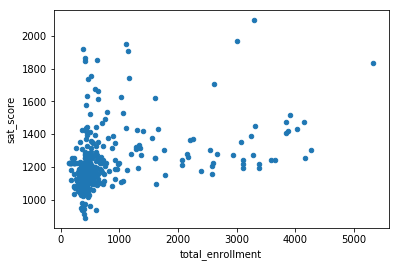

In [55]:
ax = combined.plot(x = 'total_enrollment', y = 'sat_score', kind = 'scatter')
plt.show()

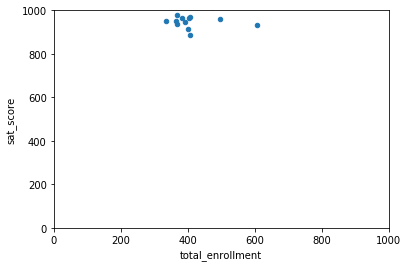

In [56]:
#if I look at the cluster in the left bottom corner :
ax = combined.plot(x = 'total_enrollment', y = 'sat_score', kind = 'scatter')
ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
plt.show()

In [57]:
#find those schools that are in this area in the bottom left corner
low_enrollement = combined[combined['sat_score']<1000]
low_enrollement = low_enrollement[low_enrollement['total_enrollment']<1000]
low_enrollement['SCHOOL NAME']

90                  INTERNATIONAL COMMUNITY HIGH SCHOOL
124                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
125                     BRONX INTERNATIONAL HIGH SCHOOL
138               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
140               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
175    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
178                       HIGH SCHOOL OF WORLD CULTURES
187                  BROOKLYN INTERNATIONAL HIGH SCHOOL
224       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
236                          IT TAKES A VILLAGE ACADEMY
252                           MULTICULTURAL HIGH SCHOOL
285              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### conclusion : the high Pierson's r is probably because of this small region, which after checking the name of the schools, turns out to be international schools and this means that the students in these classes are mostly learning English 
### this means that I should check the correlation between the sat_score and 'ell_percent'

In [58]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'AP Test Takers ',
       'Total Exams Taken', 'Number of Exams with scores 3 4 or 5',
       ...
       'Location 1', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'BBL', 'NTA', 'latitude', 'longitude', 'school_dist'],
      dtype='object', length=162)

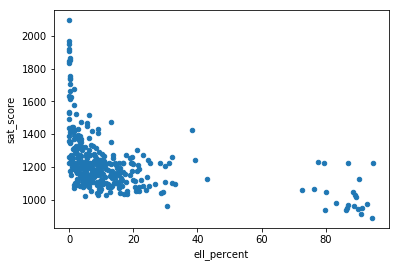

In [59]:
ax = combined.plot(x = 'ell_percent', y = 'sat_score', kind = 'scatter')
plt.show()

#### the cluster in the right bottom is representing the same schools that I found up in the previous section to be mostly international schools
#### the correlation for the english language learners is better than the total_enrollment

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


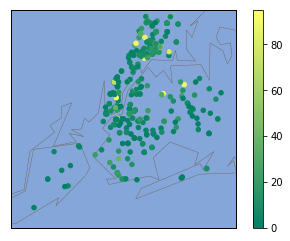

In [61]:
#plotting the language learner percentage for each school on map with colormap
latitude = combined['latitude'].tolist()
longitude = combined['longitude'].tolist()
m = Basemap(projection = 'merc', llcrnrlat= 40.49,urcrnrlat= 40.9, llcrnrlon= -74.25,urcrnrlon =  -73.69, resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F4f', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
#x, y = m(longitude, latitude)
m.scatter(longitude , latitude , s = 20, zorder=2, latlon= True , c = combined['ell_percent'] , cmap = 'summer')
plt.colorbar()
plt.show();


### school density is highest in Manhattan (the top of the map), and lower in Brooklyn, the Bronx, Queens, and Staten Island.

#### the school density is high for some regions, so it is better to plot it for each district

In [65]:
#plotting the percent of english learners for each district
districts =  combined.groupby('school_dist', as_index = False).mean()
districts.head(10)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,NUMBER OF STUDENTS / SEATS FILLED,...,priority08,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,latitude,longitude
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,115.244241,...,0.0,0.0,0.0,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377
1,02,426.608658,444.176397,424.814746,1295.599800,128.908454,201.516827,157.495833,158.713390,149.818949,...,0.0,0.0,0.0,4.203762,2.964120,1132.687384,1.104040e+06,1.070612e+09,40.739699,-73.991386
2,03,428.508982,437.977794,426.879491,1293.366267,156.183494,244.522436,193.087500,183.496764,156.005994,...,0.0,0.0,0.0,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370
3,04,397.166667,411.333333,398.666667,1207.166667,129.014423,181.685897,150.633333,123.666667,143.040289,...,0.0,0.0,0.0,11.000000,8.000000,3047.833333,1.056517e+06,1.016738e+09,40.793572,-73.942534
4,05,427.147990,438.225406,419.645423,1285.018820,85.722527,115.725275,142.464286,143.805825,120.623901,...,0.0,0.0,0.0,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251
5,06,382.003593,400.557784,382.051796,1164.613174,108.711538,159.715385,105.425000,181.028155,139.041709,...,0.0,0.0,0.0,11.178056,10.827778,2766.699444,1.226465e+06,1.171199e+09,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.640030,97.597416,...,0.0,0.0,0.0,1.692308,12.846154,58.538462,2.032562e+06,2.024050e+09,40.816815,-73.919971
7,08,386.191617,395.521230,377.868536,1159.581383,118.379371,168.020979,144.731818,215.632833,129.765099,...,0.0,0.0,0.0,7.272727,16.727273,67.909091,2.037043e+06,2.036723e+09,40.823803,-73.866087
8,09,373.751796,383.578892,374.625898,1131.956587,71.411538,104.265385,98.470000,113.398058,100.118588,...,0.0,0.0,0.0,3.550000,15.750000,5243.750000,2.022457e+06,2.027913e+09,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,168.876526,...,0.0,0.0,0.0,7.000000,12.227273,1686.045455,1.856268e+06,1.850558e+09,40.870345,-73.898360


/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


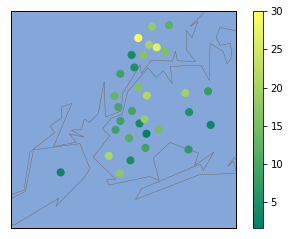

In [67]:
latitude = districts['latitude'].tolist()
longitude = districts['longitude'].tolist()
m = Basemap(projection = 'merc', llcrnrlat= 40.49,urcrnrlat= 40.9, llcrnrlon= -74.25,urcrnrlon =  -73.69, resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F4f', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
#x, y = m(longitude, latitude)
m.scatter(longitude , latitude , s = 50, zorder=2, latlon= True , c = districts['ell_percent'] , cmap = 'summer')
plt.colorbar()
plt.show();

